# DimABSA Improvement Experiments

This notebook systematically tests various improvements for Dimensional Aspect-Based Sentiment Analysis:

1. **Different Pretrained Models** (BERT-base, DeBERTa-v3, RoBERTa, VAD-BERT)
2. **Learning Rate Scheduler** with warmup
3. **Early Stopping** with best model saving
4. **Input Format Variations** (different text-aspect combinations)
5. **Architecture Improvements** (deeper heads, attention pooling, multi-layer)
6. **Ensemble Methods**

All experiments are tracked and compared at the end.

## 0. Setup & Installation

In [1]:
# Install required packages
!pip install -q transformers datasets accelerate sentencepiece

In [2]:
# Core imports
import json
import math
import random
import warnings
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, field
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset, ConcatDataset
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [3]:
# Set seeds for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Configuration

In [4]:
@dataclass
class Config:
    """Central configuration for all experiments"""
    # Data settings
    lang: str = "eng"
    domain: str = "laptop"  # "laptop" or "restaurant"
    subtask: str = "subtask_1"
    max_len: int = 256
    val_ratio: float = 0.1

    # Training settings
    batch_size: int = 16
    epochs: int = 5
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    dropout: float = 0.1

    # Early stopping
    patience: int = 3

    # Model
    model_name: str = "bert-base-uncased"

    @property
    def train_url(self) -> str:
        return f"https://raw.githubusercontent.com/DimABSA/DimABSA2026/refs/heads/main/task-dataset/track_a/{self.subtask}/{self.lang}/{self.lang}_{self.domain}_train_alltasks.jsonl"

    @property
    def dev_url(self) -> str:
        return f"https://raw.githubusercontent.com/DimABSA/DimABSA2026/refs/heads/main/task-dataset/track_a/{self.subtask}/{self.lang}/{self.lang}_{self.domain}_dev_task1.jsonl"

# Create default config
config = Config()
print(f"Configuration:")
print(f"  Language: {config.lang}")
print(f"  Domain: {config.domain}")
print(f"  Model: {config.model_name}")
print(f"  Batch size: {config.batch_size}")
print(f"  Epochs: {config.epochs}")
print(f"  Learning rate: {config.learning_rate}")

Configuration:
  Language: eng
  Domain: laptop
  Model: bert-base-uncased
  Batch size: 16
  Epochs: 5
  Learning rate: 2e-05


## 2. Data Loading & Preprocessing

In [5]:
def load_jsonl_url(url: str) -> List[Dict]:
    """Load JSONL data from URL"""
    resp = requests.get(url)
    resp.raise_for_status()
    return [json.loads(line) for line in resp.text.splitlines()]

def load_jsonl_file(filepath: str) -> List[Dict]:
    """Load JSONL data from file"""
    with open(filepath, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

def parse_data(data: List[Dict]) -> pd.DataFrame:
    """
    Parse JSONL data into DataFrame.
    Handles Quadruplet, Triplet, Aspect_VA, and Aspect formats.
    """
    records = []

    for item in data:
        text = item["Text"]
        item_id = item["ID"]

        # Determine format and extract aspects
        if "Quadruplet" in item:
            for quad in item["Quadruplet"]:
                aspect = quad.get("Aspect", "NULL")
                va = quad.get("VA", None)

                if aspect == "NULL" or va is None:
                    continue

                v_str, a_str = va.split("#")
                records.append({
                    "ID": item_id,
                    "Text": text,
                    "Aspect": aspect,
                    "Valence": float(v_str),
                    "Arousal": float(a_str)
                })

        elif "Triplet" in item:
            for trip in item["Triplet"]:
                aspect = trip.get("Aspect", "NULL")
                va = trip.get("VA", None)

                if aspect == "NULL" or va is None:
                    continue

                v_str, a_str = va.split("#")
                records.append({
                    "ID": item_id,
                    "Text": text,
                    "Aspect": aspect,
                    "Valence": float(v_str),
                    "Arousal": float(a_str)
                })

        elif "Aspect_VA" in item:
            for av in item["Aspect_VA"]:
                aspect = av.get("Aspect", "NULL")
                va = av.get("VA", None)

                if aspect == "NULL" or va is None:
                    continue

                v_str, a_str = va.split("#")
                records.append({
                    "ID": item_id,
                    "Text": text,
                    "Aspect": aspect,
                    "Valence": float(v_str),
                    "Arousal": float(a_str)
                })

        elif "Aspect" in item:
            for asp in item["Aspect"]:
                records.append({
                    "ID": item_id,
                    "Text": text,
                    "Aspect": asp,
                    "Valence": 0.0,
                    "Arousal": 0.0
                })

    df = pd.DataFrame(records)
    df = df.drop_duplicates(subset=["ID", "Aspect"], keep="first")
    return df

In [6]:
# Load data
print("Loading data...")
train_raw = load_jsonl_url(config.train_url)
print(f"Loaded {len(train_raw)} training samples")

# Parse into DataFrame
train_df = parse_data(train_raw)
print(f"Parsed {len(train_df)} aspect-level samples")

# Split into train/val
train_df, val_df = train_test_split(train_df, test_size=config.val_ratio, random_state=42)
print(f"Train: {len(train_df)}, Validation: {len(val_df)}")

# Display sample
train_df.head()

Loading data...
Loaded 4076 training samples
Parsed 3930 aspect-level samples
Train: 3537, Validation: 393


,ID,Text,Aspect,Valence,Arousal
1792,laptop_quad_train_529,i am very happy with this item .,item,7.38,7.50
3601,laptop_quad_train_2249,"after the ssd upgrade , the computer is very f...",computer,7.25,7.25
1911,laptop_quad_train_625,you can ' t beat the price for what you are ge...,computer,5.88,5.88
168,laptop_quad_dev_160,overall : i ' m super happy with this product .,product,8.00,8.38
3873,laptop_quad_train_2483,the customer / warranty service that i receive...,asus,8.00,8.33


## 2.1 Exploratory Data Analysis (EDA)

In [7]:
# Combine train and val for EDA overview
full_df = pd.concat([train_df, val_df], ignore_index=True)

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total samples: {len(full_df)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"\nUnique texts: {full_df['Text'].nunique()}")
print(f"Unique aspects: {full_df['Aspect'].nunique()}")
print(f"\nValence range: [{full_df['Valence'].min():.2f}, {full_df['Valence'].max():.2f}]")
print(f"Arousal range: [{full_df['Arousal'].min():.2f}, {full_df['Arousal'].max():.2f}]")
print(f"\nValence mean: {full_df['Valence'].mean():.2f} ± {full_df['Valence'].std():.2f}")
print(f"Arousal mean: {full_df['Arousal'].mean():.2f} ± {full_df['Arousal'].std():.2f}")

DATASET OVERVIEW
Total samples: 3930
Training samples: 3537
Validation samples: 393

Unique texts: 3218
Unique aspects: 955

Valence range: [1.00, 8.83]
Arousal range: [3.83, 8.83]

Valence mean: 5.83 ± 1.79
Arousal mean: 6.61 ± 1.06


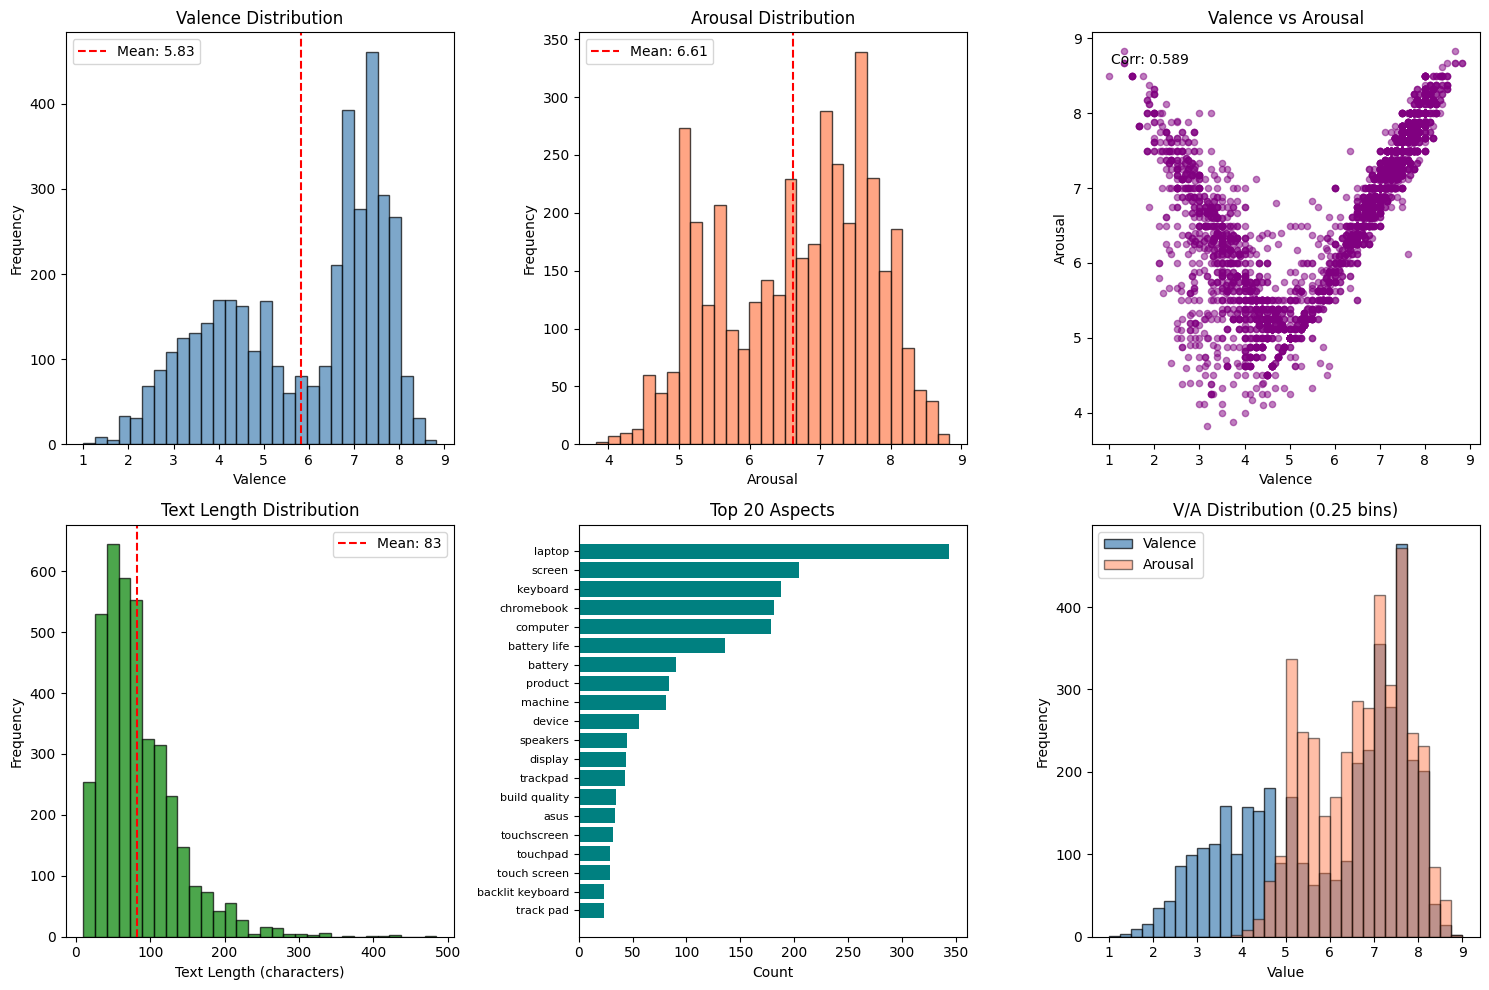

In [8]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Valence distribution
ax1 = axes[0, 0]
ax1.hist(full_df['Valence'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(full_df['Valence'].mean(), color='red', linestyle='--', label=f'Mean: {full_df["Valence"].mean():.2f}')
ax1.set_xlabel('Valence')
ax1.set_ylabel('Frequency')
ax1.set_title('Valence Distribution')
ax1.legend()

# Arousal distribution
ax2 = axes[0, 1]
ax2.hist(full_df['Arousal'], bins=30, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(full_df['Arousal'].mean(), color='red', linestyle='--', label=f'Mean: {full_df["Arousal"].mean():.2f}')
ax2.set_xlabel('Arousal')
ax2.set_ylabel('Frequency')
ax2.set_title('Arousal Distribution')
ax2.legend()

# V-A scatter plot
ax3 = axes[0, 2]
scatter = ax3.scatter(full_df['Valence'], full_df['Arousal'], alpha=0.5, c='purple', s=20)
ax3.set_xlabel('Valence')
ax3.set_ylabel('Arousal')
ax3.set_title('Valence vs Arousal')
# Add correlation
corr = full_df['Valence'].corr(full_df['Arousal'])
ax3.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax3.transAxes, fontsize=10, verticalalignment='top')

# Text length distribution
ax4 = axes[1, 0]
text_lengths = full_df['Text'].str.len()
ax4.hist(text_lengths, bins=30, edgecolor='black', alpha=0.7, color='green')
ax4.axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Mean: {text_lengths.mean():.0f}')
ax4.set_xlabel('Text Length (characters)')
ax4.set_ylabel('Frequency')
ax4.set_title('Text Length Distribution')
ax4.legend()

# Aspect frequency (top 20)
ax5 = axes[1, 1]
aspect_counts = full_df['Aspect'].value_counts().head(20)
ax5.barh(range(len(aspect_counts)), aspect_counts.values, color='teal')
ax5.set_yticks(range(len(aspect_counts)))
ax5.set_yticklabels(aspect_counts.index, fontsize=8)
ax5.set_xlabel('Count')
ax5.set_title('Top 20 Aspects')
ax5.invert_yaxis()

# Valence binned distribution (0.25 bins)
ax6 = axes[1, 2]
bins_025 = np.arange(1, 9.25, 0.25)
ax6.hist(full_df['Valence'], bins=bins_025, edgecolor='black', alpha=0.7, color='steelblue', label='Valence')
ax6.hist(full_df['Arousal'], bins=bins_025, edgecolor='black', alpha=0.5, color='coral', label='Arousal')
ax6.set_xlabel('Value')
ax6.set_ylabel('Frequency')
ax6.set_title('V/A Distribution (0.25 bins)')
ax6.legend()

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Detailed statistics
print("="*60)
print("DETAILED STATISTICS")
print("="*60)

print("\n--- Valence Statistics ---")
print(full_df['Valence'].describe())

print("\n--- Arousal Statistics ---")
print(full_df['Arousal'].describe())

print("\n--- Text Length Statistics ---")
print(full_df['Text'].str.len().describe())

print("\n--- Aspect Length Statistics ---")
print(full_df['Aspect'].str.len().describe())

# Word count
word_counts = full_df['Text'].str.split().str.len()
print("\n--- Word Count Statistics ---")
print(word_counts.describe())

# Aspect statistics
print(f"\n--- Aspect Statistics ---")
print(f"Total unique aspects: {full_df['Aspect'].nunique()}")
print(f"Aspects per text (mean): {full_df.groupby('Text').size().mean():.2f}")
print(f"Aspects per text (max): {full_df.groupby('Text').size().max()}")

DETAILED STATISTICS

--- Valence Statistics ---
count    3930.000000
mean        5.828336
std         1.790333
min         1.000000
25%         4.250000
50%         6.500000
75%         7.380000
max         8.830000
Name: Valence, dtype: float64

--- Arousal Statistics ---
count    3930.000000
mean        6.613975
std         1.055065
min         3.830000
25%         5.620000
50%         6.830000
75%         7.500000
max         8.830000
Name: Arousal, dtype: float64

--- Text Length Statistics ---
count    3930.000000
mean       82.807888
std        51.661136
min        10.000000
25%        47.000000
50%        72.000000
75%       107.000000
max       485.000000
Name: Text, dtype: float64

--- Aspect Length Statistics ---
count    3930.000000
mean        8.900254
std         4.367296
min         2.000000
25%         6.000000
50%         8.000000
75%        11.000000
max        37.000000
Name: Aspect, dtype: float64

--- Word Count Statistics ---
count    3930.000000
mean       17.2165

V-A QUADRANT ANALYSIS

Quadrant distribution (midpoint = 5.0):
  High V, High A (excited/happy):  2566 (65.3%)
  High V, Low A (calm/content):      13 (0.3%)
  Low V, High A (angry/anxious):   1166 (29.7%)
  Low V, Low A (sad/bored):         185 (4.7%)


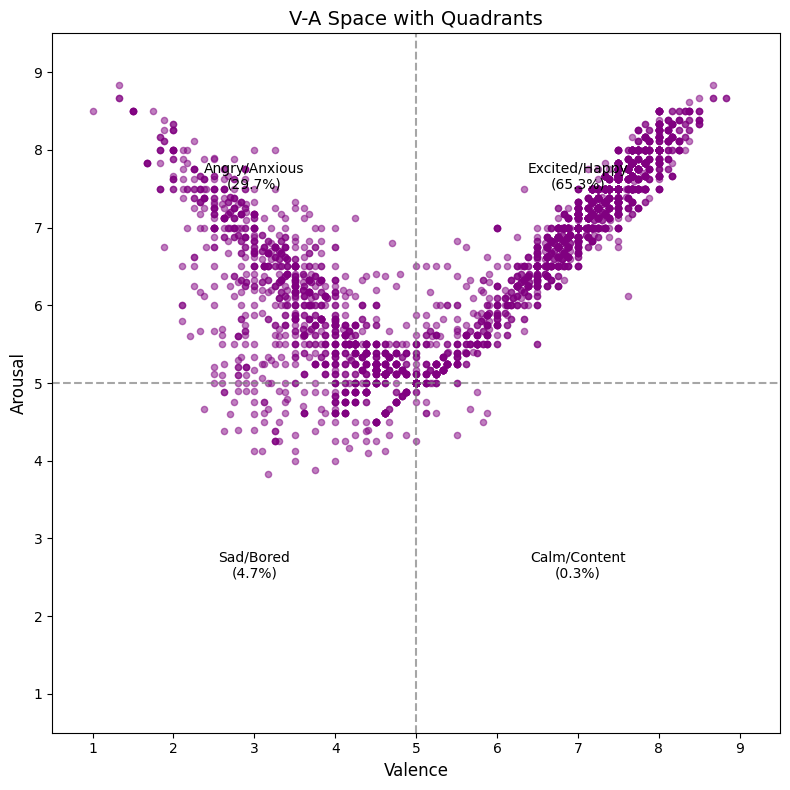

In [10]:
# V-A quadrant analysis
print("="*60)
print("V-A QUADRANT ANALYSIS")
print("="*60)

v_mid = 5.0  # Midpoint of 1-9 scale
a_mid = 5.0

# Define quadrants
high_v_high_a = ((full_df['Valence'] >= v_mid) & (full_df['Arousal'] >= a_mid)).sum()
high_v_low_a = ((full_df['Valence'] >= v_mid) & (full_df['Arousal'] < a_mid)).sum()
low_v_high_a = ((full_df['Valence'] < v_mid) & (full_df['Arousal'] >= a_mid)).sum()
low_v_low_a = ((full_df['Valence'] < v_mid) & (full_df['Arousal'] < a_mid)).sum()

total = len(full_df)
print(f"\nQuadrant distribution (midpoint = 5.0):")
print(f"  High V, High A (excited/happy):  {high_v_high_a:4d} ({100*high_v_high_a/total:.1f}%)")
print(f"  High V, Low A (calm/content):    {high_v_low_a:4d} ({100*high_v_low_a/total:.1f}%)")
print(f"  Low V, High A (angry/anxious):   {low_v_high_a:4d} ({100*low_v_high_a/total:.1f}%)")
print(f"  Low V, Low A (sad/bored):        {low_v_low_a:4d} ({100*low_v_low_a/total:.1f}%)")

# Visualize quadrants
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(full_df['Valence'], full_df['Arousal'], alpha=0.5, c='purple', s=20)
ax.axhline(y=a_mid, color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=v_mid, color='gray', linestyle='--', alpha=0.7)
ax.set_xlabel('Valence', fontsize=12)
ax.set_ylabel('Arousal', fontsize=12)
ax.set_title('V-A Space with Quadrants', fontsize=14)
ax.set_xlim(0.5, 9.5)
ax.set_ylim(0.5, 9.5)

# Add quadrant labels
ax.text(7, 7.5, f'Excited/Happy\n({100*high_v_high_a/total:.1f}%)', fontsize=10, ha='center')
ax.text(7, 2.5, f'Calm/Content\n({100*high_v_low_a/total:.1f}%)', fontsize=10, ha='center')
ax.text(3, 7.5, f'Angry/Anxious\n({100*low_v_high_a/total:.1f}%)', fontsize=10, ha='center')
ax.text(3, 2.5, f'Sad/Bored\n({100*low_v_low_a/total:.1f}%)', fontsize=10, ha='center')

plt.tight_layout()
plt.savefig('va_quadrants.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# Sample examples from each quadrant
print("="*60)
print("SAMPLE EXAMPLES FROM EACH QUADRANT")
print("="*60)

def show_samples(df, condition, name, n=3):
    samples = df[condition].head(n)
    print(f"\n--- {name} ---")
    for _, row in samples.iterrows():
        print(f"  Text: {row['Text'][:80]}...")
        print(f"  Aspect: {row['Aspect']}")
        print(f"  V={row['Valence']:.1f}, A={row['Arousal']:.1f}")
        print()

show_samples(full_df, (full_df['Valence'] >= 7) & (full_df['Arousal'] >= 6), "High Valence, High Arousal")
show_samples(full_df, (full_df['Valence'] >= 7) & (full_df['Arousal'] <= 4), "High Valence, Low Arousal")
show_samples(full_df, (full_df['Valence'] <= 3) & (full_df['Arousal'] >= 6), "Low Valence, High Arousal")
show_samples(full_df, (full_df['Valence'] <= 3) & (full_df['Arousal'] <= 4), "Low Valence, Low Arousal")

SAMPLE EXAMPLES FROM EACH QUADRANT

--- High Valence, High Arousal ---
  Text: i am very happy with this item ....
  Aspect: item
  V=7.4, A=7.5

  Text: after the ssd upgrade , the computer is very fast ....
  Aspect: computer
  V=7.2, A=7.2

  Text: overall : i ' m super happy with this product ....
  Aspect: product
  V=8.0, A=8.4


--- High Valence, Low Arousal ---

--- Low Valence, High Arousal ---
  Text: battery doesn ' t last nearly as long as advertised ....
  Aspect: battery
  V=3.0, A=6.7

  Text: one of the keys is especially flimsy and feels like it could break at any moment...
  Aspect: one of the keys
  V=2.8, A=7.6

  Text: absolutly horrible product , cheap components make for unreliable products , but...
  Aspect: components
  V=2.2, A=7.8


--- Low Valence, Low Arousal ---


## 3. Dataset Classes with Different Input Formats

In [12]:
class InputFormat:
    """Different ways to combine text and aspect"""

    @staticmethod
    def sep_format(text: str, aspect: str) -> str:
        """Format: text [SEP] aspect"""
        return f"{text} [SEP] {aspect}"

    @staticmethod
    def colon_format(text: str, aspect: str) -> str:
        """Format: aspect: text"""
        return f"{aspect}: {text}"

    @staticmethod
    def question_format(text: str, aspect: str) -> str:
        """Format: What is the sentiment toward aspect? text"""
        return f"What is the sentiment toward {aspect}? {text}"

    @staticmethod
    def marker_format(text: str, aspect: str) -> str:
        """Format: [ASPECT] aspect [/ASPECT] text"""
        return f"[ASPECT] {aspect} [/ASPECT] {text}"

    @staticmethod
    def detailed_format(text: str, aspect: str) -> str:
        """Format: The aspect 'aspect' in the review: text"""
        return f"The aspect '{aspect}' in the review: {text}"


class DimABSADataset(Dataset):
    """
    Flexible dataset for DimABSA with configurable input format.
    """
    def __init__(
        self,
        dataframe: pd.DataFrame,
        tokenizer,
        max_len: int = 128,
        input_format: str = "sep",  # "sep", "colon", "question", "marker", "detailed"
        normalize_labels: bool = False,
        va_max: float = 9.0
    ):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.normalize_labels = normalize_labels
        self.va_max = va_max

        # Select input format function
        format_map = {
            "sep": InputFormat.sep_format,
            "colon": InputFormat.colon_format,
            "question": InputFormat.question_format,
            "marker": InputFormat.marker_format,
            "detailed": InputFormat.detailed_format
        }
        self.format_fn = format_map.get(input_format, InputFormat.sep_format)

        # Store data
        self.texts = dataframe["Text"].tolist()
        self.aspects = dataframe["Aspect"].tolist()
        self.valences = dataframe["Valence"].values.astype(float)
        self.arousals = dataframe["Arousal"].values.astype(float)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Create input text
        input_text = self.format_fn(self.texts[idx], self.aspects[idx])

        # Tokenize
        encoded = self.tokenizer(
            input_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        # Get labels
        valence = self.valences[idx]
        arousal = self.arousals[idx]

        if self.normalize_labels:
            valence = valence / self.va_max
            arousal = arousal / self.va_max

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor([valence, arousal], dtype=torch.float)
        }

In [13]:
# Test different formats
sample_text = "The keyboard is excellent and very responsive"
sample_aspect = "keyboard"

print("Input Format Examples:")
print(f"  sep:      {InputFormat.sep_format(sample_text, sample_aspect)}")
print(f"  colon:    {InputFormat.colon_format(sample_text, sample_aspect)}")
print(f"  question: {InputFormat.question_format(sample_text, sample_aspect)}")
print(f"  marker:   {InputFormat.marker_format(sample_text, sample_aspect)}")
print(f"  detailed: {InputFormat.detailed_format(sample_text, sample_aspect)}")

Input Format Examples:
  sep:      The keyboard is excellent and very responsive [SEP] keyboard
  colon:    keyboard: The keyboard is excellent and very responsive
  question: What is the sentiment toward keyboard? The keyboard is excellent and very responsive
  marker:   [ASPECT] keyboard [/ASPECT] The keyboard is excellent and very responsive
  detailed: The aspect 'keyboard' in the review: The keyboard is excellent and very responsive


## 4. Model Architectures

In [14]:
class BaseRegressor(nn.Module):
    """Base class with common functionality"""

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class SimpleRegressor(BaseRegressor):
    """
    Simple [CLS] -> Linear regression head.
    Baseline architecture.
    """
    def __init__(self, model_name: str, dropout: float = 0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        x = self.dropout(cls_output)
        return self.regressor(x)


class DeeperRegressor(BaseRegressor):
    """
    [CLS] -> MLP with hidden layers.
    More capacity in the regression head.
    """
    def __init__(self, model_name: str, dropout: float = 0.2, hidden_dims: List[int] = [512, 128]):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        layers = []
        prev_dim = hidden_size
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 2))

        self.regressor = nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        return self.regressor(cls_output)


class SeparateHeadsRegressor(BaseRegressor):
    """
    Separate prediction heads for Valence and Arousal.
    Allows independent learning for each dimension.
    """
    def __init__(self, model_name: str, dropout: float = 0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.dropout = nn.Dropout(dropout)
        self.valence_head = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )
        self.arousal_head = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = self.dropout(outputs.last_hidden_state[:, 0])

        valence = self.valence_head(cls_output)
        arousal = self.arousal_head(cls_output)

        return torch.cat([valence, arousal], dim=1)


class MultiLayerRegressor(BaseRegressor):
    """
    Concatenates [CLS] from last N layers.
    Captures features at different abstraction levels.
    """
    def __init__(self, model_name: str, dropout: float = 0.1, num_layers: int = 4):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name, output_hidden_states=True)
        hidden_size = self.encoder.config.hidden_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size * num_layers, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states

        # Concatenate [CLS] from last N layers
        cls_concat = torch.cat(
            [hidden_states[-i][:, 0] for i in range(1, self.num_layers + 1)],
            dim=1
        )

        x = self.dropout(cls_concat)
        return self.regressor(x)


class AttentionPoolingRegressor(BaseRegressor):
    """
    Uses attention pooling instead of just [CLS].
    Learns to weight all tokens dynamically.
    """
    def __init__(self, model_name: str, dropout: float = 0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.attention = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [batch, seq_len, hidden]

        # Compute attention weights
        attn_scores = self.attention(hidden_states).squeeze(-1)  # [batch, seq_len]
        attn_scores = attn_scores.masked_fill(attention_mask == 0, -1e9)
        attn_weights = F.softmax(attn_scores, dim=1)  # [batch, seq_len]

        # Weighted sum
        pooled = torch.bmm(attn_weights.unsqueeze(1), hidden_states).squeeze(1)  # [batch, hidden]

        x = self.dropout(pooled)
        return self.regressor(x)


class ClassificationRegressor(BaseRegressor):
    """
    Classification approach: bins continuous V/A values into discrete classes (0.25 bin width).
    Predicts class probabilities and converts back to continuous values.
    """
    def __init__(self, model_name: str, dropout: float = 0.1,
                 num_bins: int = 32, va_min: float = 1.0, va_max: float = 9.0):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.num_bins = num_bins
        self.va_min = va_min
        self.va_max = va_max
        self.bin_width = (va_max - va_min) / num_bins  # 0.25 for 32 bins over range 8

        # Compute bin centers for converting back to continuous
        self.register_buffer('bin_centers',
            torch.linspace(va_min + self.bin_width/2, va_max - self.bin_width/2, num_bins))

        self.dropout = nn.Dropout(dropout)
        self.valence_classifier = nn.Linear(hidden_size, num_bins)
        self.arousal_classifier = nn.Linear(hidden_size, num_bins)

    def value_to_bin(self, value: torch.Tensor) -> torch.Tensor:
        """Convert continuous value to bin index"""
        bin_idx = ((value - self.va_min) / self.bin_width).long()
        return bin_idx.clamp(0, self.num_bins - 1)

    def logits_to_value(self, logits: torch.Tensor) -> torch.Tensor:
        """Convert logits to continuous value using soft expectation"""
        probs = F.softmax(logits, dim=-1)
        return (probs * self.bin_centers).sum(dim=-1)

    def forward(self, input_ids, attention_mask, return_logits=False):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = self.dropout(outputs.last_hidden_state[:, 0])

        v_logits = self.valence_classifier(cls_output)
        a_logits = self.arousal_classifier(cls_output)

        if return_logits:
            return v_logits, a_logits

        # Convert to continuous values using soft expectation
        v_pred = self.logits_to_value(v_logits)
        a_pred = self.logits_to_value(a_logits)

        return torch.stack([v_pred, a_pred], dim=1)


class CombinedRegressor(BaseRegressor):
    """
    Combined approach: uses both regression and classification heads.
    Final prediction is weighted average of both.
    """
    def __init__(self, model_name: str, dropout: float = 0.1,
                 num_bins: int = 32, va_min: float = 1.0, va_max: float = 9.0,
                 reg_weight: float = 0.5):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.num_bins = num_bins
        self.va_min = va_min
        self.va_max = va_max
        self.bin_width = (va_max - va_min) / num_bins
        self.reg_weight = reg_weight

        self.register_buffer('bin_centers',
            torch.linspace(va_min + self.bin_width/2, va_max - self.bin_width/2, num_bins))

        self.dropout = nn.Dropout(dropout)

        # Regression head
        self.regressor = nn.Linear(hidden_size, 2)

        # Classification heads
        self.valence_classifier = nn.Linear(hidden_size, num_bins)
        self.arousal_classifier = nn.Linear(hidden_size, num_bins)

    def value_to_bin(self, value: torch.Tensor) -> torch.Tensor:
        bin_idx = ((value - self.va_min) / self.bin_width).long()
        return bin_idx.clamp(0, self.num_bins - 1)

    def logits_to_value(self, logits: torch.Tensor) -> torch.Tensor:
        probs = F.softmax(logits, dim=-1)
        return (probs * self.bin_centers).sum(dim=-1)

    def forward(self, input_ids, attention_mask, return_all=False):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = self.dropout(outputs.last_hidden_state[:, 0])

        # Regression predictions
        reg_pred = self.regressor(cls_output)

        # Classification predictions
        v_logits = self.valence_classifier(cls_output)
        a_logits = self.arousal_classifier(cls_output)

        v_cls = self.logits_to_value(v_logits)
        a_cls = self.logits_to_value(a_logits)
        cls_pred = torch.stack([v_cls, a_cls], dim=1)

        # Combined prediction (weighted average)
        combined_pred = self.reg_weight * reg_pred + (1 - self.reg_weight) * cls_pred

        if return_all:
            return combined_pred, reg_pred, v_logits, a_logits

        return combined_pred


# Model registry
MODEL_REGISTRY = {
    "simple": SimpleRegressor,
    "deeper": DeeperRegressor,
    "separate_heads": SeparateHeadsRegressor,
    "multi_layer": MultiLayerRegressor,
    "attention_pooling": AttentionPoolingRegressor,
    "classification": ClassificationRegressor,
    "combined": CombinedRegressor
}

print("Available architectures:", list(MODEL_REGISTRY.keys()))

Available architectures: ['simple', 'deeper', 'separate_heads', 'multi_layer', 'attention_pooling', 'classification', 'combined']


## 5. Loss Functions

In [15]:
class WeightedMSELoss(nn.Module):
    """MSE with configurable weights for Valence and Arousal"""
    def __init__(self, valence_weight: float = 1.0, arousal_weight: float = 1.0):
        super().__init__()
        self.register_buffer('weights', torch.tensor([valence_weight, arousal_weight]))

    def forward(self, pred, target):
        squared_diff = (pred - target) ** 2
        weighted_loss = squared_diff * self.weights
        return weighted_loss.mean()


class ClassificationLoss(nn.Module):
    """Cross-entropy loss for binned classification approach"""
    def __init__(self, num_bins: int = 32, va_min: float = 1.0, va_max: float = 9.0,
                 label_smoothing: float = 0.1):
        super().__init__()
        self.num_bins = num_bins
        self.va_min = va_min
        self.va_max = va_max
        self.bin_width = (va_max - va_min) / num_bins
        self.ce_loss = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    def value_to_bin(self, value: torch.Tensor) -> torch.Tensor:
        bin_idx = ((value - self.va_min) / self.bin_width).long()
        return bin_idx.clamp(0, self.num_bins - 1)

    def forward(self, v_logits, a_logits, target):
        v_target = self.value_to_bin(target[:, 0])
        a_target = self.value_to_bin(target[:, 1])

        v_loss = self.ce_loss(v_logits, v_target)
        a_loss = self.ce_loss(a_logits, a_target)

        return (v_loss + a_loss) / 2


class CombinedModelLoss(nn.Module):
    """Combined loss for regression + classification model"""
    def __init__(self, num_bins: int = 32, va_min: float = 1.0, va_max: float = 9.0,
                 mse_weight: float = 0.5, ce_weight: float = 0.5, label_smoothing: float = 0.1):
        super().__init__()
        self.mse_weight = mse_weight
        self.ce_weight = ce_weight
        self.mse_loss = nn.MSELoss()
        self.cls_loss = ClassificationLoss(num_bins, va_min, va_max, label_smoothing)

    def forward(self, combined_pred, reg_pred, v_logits, a_logits, target):
        mse = self.mse_loss(reg_pred, target)
        ce = self.cls_loss(v_logits, a_logits, target)
        return self.mse_weight * mse + self.ce_weight * ce


# Loss registry
LOSS_REGISTRY = {
    "mse": nn.MSELoss,
    "huber": nn.SmoothL1Loss,
    "weighted_mse": WeightedMSELoss,
    "classification": ClassificationLoss,
    "combined_loss": CombinedModelLoss
}

print("Available loss functions:", list(LOSS_REGISTRY.keys()))

Available loss functions: ['mse', 'huber', 'weighted_mse', 'classification', 'combined_loss']


## 6. Training Framework

In [ ]:
@dataclass
class TrainingResult:
    """Store results from a training run"""
    experiment_name: str
    train_losses: List[float] = field(default_factory=list)
    val_losses: List[float] = field(default_factory=list)
    val_rmse: List[float] = field(default_factory=list)
    val_rmse_norm: List[float] = field(default_factory=list)
    val_pcc_v: List[float] = field(default_factory=list)
    val_pcc_a: List[float] = field(default_factory=list)
    best_rmse: float = float('inf')
    best_epoch: int = 0
    config: Dict = field(default_factory=dict)


def compute_metrics(preds: np.ndarray, labels: np.ndarray, normalize: bool = True) -> Dict[str, float]:
    """
    Compute RMSE and Pearson correlation matching OFFICIAL DimABSA evaluation script.

    Official RMSE formula (from evaluate.py):
        RMSE_VA = sqrt( sum((V_p - V_g)^2 + (A_p - A_g)^2) / N )

    Where N = number of samples (not 2*N)
    Normalized: RMSE_VA / sqrt(128)

    This matches the evaluate_predictions_task1() function in the official script.
    """
    pred_v, pred_a = preds[:, 0], preds[:, 1]
    gold_v, gold_a = labels[:, 0], labels[:, 1]
    n_samples = len(pred_v)


    v_squared_errors = (pred_v - gold_v) ** 2
    a_squared_errors = (pred_a - gold_a) ** 2


    rmse = np.sqrt((np.sum(v_squared_errors) + np.sum(a_squared_errors)) / n_samples)


    rmse_norm = rmse / np.sqrt(128)


    pcc_v = pearsonr(pred_v, gold_v)[0]
    pcc_a = pearsonr(pred_a, gold_a)[0]


    rmse_v = np.sqrt(np.mean(v_squared_errors))
    rmse_a = np.sqrt(np.mean(a_squared_errors))

    return {
        "rmse": rmse,           
        "rmse_norm": rmse_norm,
        "rmse_v": rmse_v,
        "rmse_a": rmse_a,
        "pcc_v": pcc_v,
        "pcc_a": pcc_a
    }


def official_metrics_summary(preds: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
    metrics = compute_metrics(preds, labels)
    print(f"\n{'='*50}")
    print("OFFICIAL EVALUATION METRICS (Task 1)")
    print(f"{'='*50}")
    print(f"PCC_V:   {metrics['pcc_v']:.4f}")
    print(f"PCC_A:   {metrics['pcc_a']:.4f}")
    print(f"RMSE_VA: {metrics['rmse_norm']:.4f}  (normalized, with --do_norm)")
    print(f"RMSE_VA: {metrics['rmse']:.4f}  (raw, without --do_norm)")
    print(f"{'='*50}")
    return metrics

In [17]:
class Trainer:
    """Trainer with early stopping and learning rate scheduling"""

    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer,
        scheduler,
        loss_fn,
        device: torch.device,
        patience: int = 3,
        clip_grad: float = 1.0
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.device = device
        self.patience = patience
        self.clip_grad = clip_grad

        self.best_rmse = float('inf')
        self.best_model_state = None
        self.patience_counter = 0

    def train_epoch(self) -> float:
        self.model.train()
        total_loss = 0

        for batch in tqdm(self.train_loader, desc="Training", leave=False):
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask)
            loss = self.loss_fn(outputs, labels)
            loss.backward()

            # Gradient clipping
            if self.clip_grad:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)

            self.optimizer.step()
            if self.scheduler:
                self.scheduler.step()

            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    @torch.no_grad()
    def evaluate(self) -> Tuple[float, Dict[str, float]]:
        self.model.eval()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in self.val_loader:
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            outputs = self.model(input_ids, attention_mask)
            loss = self.loss_fn(outputs, labels)

            total_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

        preds = np.vstack(all_preds)
        labels = np.vstack(all_labels)
        metrics = compute_metrics(preds, labels)

        return total_loss / len(self.val_loader), metrics

    def train(self, epochs: int, experiment_name: str = "experiment") -> TrainingResult:
        result = TrainingResult(experiment_name=experiment_name)

        for epoch in range(1, epochs + 1):
            train_loss = self.train_epoch()
            val_loss, metrics = self.evaluate()

            result.train_losses.append(train_loss)
            result.val_losses.append(val_loss)
            result.val_rmse.append(metrics["rmse"])
            result.val_rmse_norm.append(metrics["rmse_norm"])
            result.val_pcc_v.append(metrics["pcc_v"])
            result.val_pcc_a.append(metrics["pcc_a"])

            print(f"Epoch {epoch}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"RMSE: {metrics['rmse']:.4f} | "
                  f"RMSE_norm: {metrics['rmse_norm']:.4f} | "
                  f"PCC_V: {metrics['pcc_v']:.4f} | "
                  f"PCC_A: {metrics['pcc_a']:.4f}")

            # Early stopping check (using raw RMSE for consistency)
            if metrics["rmse"] < self.best_rmse:
                self.best_rmse = metrics["rmse"]
                self.best_model_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
                self.patience_counter = 0
                result.best_rmse = metrics["rmse"]
                result.best_epoch = epoch
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        # Restore best model
        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)

        return result

In [18]:
def run_experiment(
    name: str,
    model_name: str,
    architecture: str,
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    input_format: str = "sep",
    loss_type: str = "mse",
    batch_size: int = 16,
    epochs: int = 5,
    lr: float = 2e-5,
    warmup_ratio: float = 0.1,
    dropout: float = 0.1,
    patience: int = 3,
    max_len: int = 128
) -> TrainingResult:
    """
    Run a single experiment with specified configuration.
    """
    print(f"\n{'='*60}")
    print(f"Experiment: {name}")
    print(f"{'='*60}")
    print(f"Model: {model_name}")
    print(f"Architecture: {architecture}")
    print(f"Input format: {input_format}")
    print(f"Loss: {loss_type}")
    print(f"{'='*60}\n")

    set_seed(42)

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Datasets
    train_dataset = DimABSADataset(train_df, tokenizer, max_len=max_len, input_format=input_format)
    val_dataset = DimABSADataset(val_df, tokenizer, max_len=max_len, input_format=input_format)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model_class = MODEL_REGISTRY[architecture]
    model = model_class(model_name, dropout=dropout).to(DEVICE)
    print(f"Model parameters: {model.count_parameters():,}")

    # Loss
    loss_fn = LOSS_REGISTRY[loss_type]()

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    # Scheduler
    total_steps = len(train_loader) * epochs
    warmup_steps = int(warmup_ratio * total_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn=loss_fn,
        device=DEVICE,
        patience=patience
    )

    # Train
    result = trainer.train(epochs, experiment_name=name)
    result.config = {
        "model_name": model_name,
        "architecture": architecture,
        "input_format": input_format,
        "loss_type": loss_type,
        "batch_size": batch_size,
        "lr": lr,
        "dropout": dropout
    }

    print(f"\nBest RMSE: {result.best_rmse:.4f} at epoch {result.best_epoch}")

    return result

In [19]:
def run_classification_experiment(
    name: str,
    model_name: str,
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    input_format: str = "sep",
    batch_size: int = 16,
    epochs: int = 5,
    lr: float = 2e-5,
    warmup_ratio: float = 0.1,
    dropout: float = 0.1,
    patience: int = 3,
    max_len: int = 128,
    num_bins: int = 32,
    va_min: float = 1.0,
    va_max: float = 9.0
) -> TrainingResult:
    """
    Run classification experiment with 0.25 bins.
    """
    print(f"\n{'='*60}")
    print(f"Experiment: {name}")
    print(f"{'='*60}")
    print(f"Model: {model_name}")
    print(f"Architecture: classification")
    print(f"Num bins: {num_bins} (bin width: {(va_max-va_min)/num_bins:.2f})")
    print(f"{'='*60}\n")

    set_seed(42)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_dataset = DimABSADataset(train_df, tokenizer, max_len=max_len, input_format=input_format)
    val_dataset = DimABSADataset(val_df, tokenizer, max_len=max_len, input_format=input_format)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = ClassificationRegressor(model_name, dropout=dropout, num_bins=num_bins,
                                    va_min=va_min, va_max=va_max).to(DEVICE)
    print(f"Model parameters: {model.count_parameters():,}")

    loss_fn = ClassificationLoss(num_bins=num_bins, va_min=va_min, va_max=va_max)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = len(train_loader) * epochs
    warmup_steps = int(warmup_ratio * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    result = TrainingResult(experiment_name=name)
    best_rmse = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc="Training", leave=False):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            v_logits, a_logits = model(input_ids, attention_mask, return_logits=True)
            loss = loss_fn(v_logits, a_logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)
                outputs = model(input_ids, attention_mask)  # Returns continuous values
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        preds = np.vstack(all_preds)
        labels_np = np.vstack(all_labels)
        metrics = compute_metrics(preds, labels_np)

        result.train_losses.append(train_loss)
        result.val_rmse.append(metrics["rmse"])
        result.val_pcc_v.append(metrics["pcc_v"])
        result.val_pcc_a.append(metrics["pcc_a"])

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | "
              f"RMSE: {metrics['rmse']:.4f} | PCC_V: {metrics['pcc_v']:.4f} | PCC_A: {metrics['pcc_a']:.4f}")

        if metrics["rmse"] < best_rmse:
            best_rmse = metrics["rmse"]
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            result.best_rmse = metrics["rmse"]
            result.best_epoch = epoch
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    result.config = {
        "model_name": model_name,
        "architecture": "classification",
        "input_format": input_format,
        "loss_type": "classification",
        "num_bins": num_bins
    }
    print(f"\nBest RMSE: {result.best_rmse:.4f} at epoch {result.best_epoch}")
    return result


def run_combined_experiment(
    name: str,
    model_name: str,
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    input_format: str = "sep",
    batch_size: int = 16,
    epochs: int = 5,
    lr: float = 2e-5,
    warmup_ratio: float = 0.1,
    dropout: float = 0.1,
    patience: int = 3,
    max_len: int = 128,
    num_bins: int = 32,
    va_min: float = 1.0,
    va_max: float = 9.0,
    reg_weight: float = 0.5
) -> TrainingResult:
    """
    Run combined regression + classification experiment.
    """
    print(f"\n{'='*60}")
    print(f"Experiment: {name}")
    print(f"{'='*60}")
    print(f"Model: {model_name}")
    print(f"Architecture: combined (regression + classification)")
    print(f"Regression weight: {reg_weight}, Classification weight: {1-reg_weight}")
    print(f"{'='*60}\n")

    set_seed(42)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_dataset = DimABSADataset(train_df, tokenizer, max_len=max_len, input_format=input_format)
    val_dataset = DimABSADataset(val_df, tokenizer, max_len=max_len, input_format=input_format)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = CombinedRegressor(model_name, dropout=dropout, num_bins=num_bins,
                              va_min=va_min, va_max=va_max, reg_weight=reg_weight).to(DEVICE)
    print(f"Model parameters: {model.count_parameters():,}")

    loss_fn = CombinedModelLoss(num_bins=num_bins, va_min=va_min, va_max=va_max)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = len(train_loader) * epochs
    warmup_steps = int(warmup_ratio * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    result = TrainingResult(experiment_name=name)
    best_rmse = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc="Training", leave=False):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            combined_pred, reg_pred, v_logits, a_logits = model(input_ids, attention_mask, return_all=True)
            loss = loss_fn(combined_pred, reg_pred, v_logits, a_logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)
                outputs = model(input_ids, attention_mask)  # Returns combined prediction
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        preds = np.vstack(all_preds)
        labels_np = np.vstack(all_labels)
        metrics = compute_metrics(preds, labels_np)

        result.train_losses.append(train_loss)
        result.val_rmse.append(metrics["rmse"])
        result.val_pcc_v.append(metrics["pcc_v"])
        result.val_pcc_a.append(metrics["pcc_a"])

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | "
              f"RMSE: {metrics['rmse']:.4f} | PCC_V: {metrics['pcc_v']:.4f} | PCC_A: {metrics['pcc_a']:.4f}")

        if metrics["rmse"] < best_rmse:
            best_rmse = metrics["rmse"]
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            result.best_rmse = metrics["rmse"]
            result.best_epoch = epoch
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    result.config = {
        "model_name": model_name,
        "architecture": "combined",
        "input_format": input_format,
        "loss_type": "combined_loss",
        "num_bins": num_bins,
        "reg_weight": reg_weight
    }
    print(f"\nBest RMSE: {result.best_rmse:.4f} at epoch {result.best_epoch}")
    return result

## 7. Run Experiments

In [20]:
# Store all results
all_results = []

### Experiment 1: Baseline (BERT-base + Simple)

In [21]:
result_baseline = run_experiment(
    name="Baseline (BERT-base + Simple)",
    model_name="bert-base-uncased",
    architecture="simple",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_baseline)


Experiment: Baseline (BERT-base + Simple)
Model: bert-base-uncased
Architecture: simple
Input format: sep
Loss: mse



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model parameters: 109,483,778


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 8.6138 | Val Loss: 0.8006 | RMSE: 1.2731 | RMSE_norm: 0.1125 | PCC_V: 0.8666 | PCC_A: 0.6506


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6671 | Val Loss: 0.7341 | RMSE: 1.2207 | RMSE_norm: 0.1079 | PCC_V: 0.8800 | PCC_A: 0.6889


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4575 | Val Loss: 0.6007 | RMSE: 1.1043 | RMSE_norm: 0.0976 | PCC_V: 0.8975 | PCC_A: 0.7186


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3356 | Val Loss: 0.6852 | RMSE: 1.1797 | RMSE_norm: 0.1043 | PCC_V: 0.8929 | PCC_A: 0.7074


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2665 | Val Loss: 0.6942 | RMSE: 1.1865 | RMSE_norm: 0.1049 | PCC_V: 0.8919 | PCC_A: 0.7022

Best RMSE: 1.1043 at epoch 3


### Experiment 2: DeBERTa-v3 Model

In [22]:
result_deberta = run_experiment(
    name="DeBERTa-v3 + Simple",
    model_name="microsoft/deberta-v3-base",
    architecture="simple",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_deberta)


Experiment: DeBERTa-v3 + Simple
Model: microsoft/deberta-v3-base
Architecture: simple
Input format: sep
Loss: mse



tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Model parameters: 183,833,090


Training:   0%|          | 0/222 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch 1/5 | Train Loss: 9.5143 | Val Loss: 1.1442 | RMSE: 1.5233 | RMSE_norm: 0.1346 | PCC_V: 0.8775 | PCC_A: 0.6394


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6980 | Val Loss: 0.8502 | RMSE: 1.3131 | RMSE_norm: 0.1161 | PCC_V: 0.8887 | PCC_A: 0.6759


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.5019 | Val Loss: 0.6501 | RMSE: 1.1498 | RMSE_norm: 0.1016 | PCC_V: 0.9029 | PCC_A: 0.7046


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.4003 | Val Loss: 0.6736 | RMSE: 1.1701 | RMSE_norm: 0.1034 | PCC_V: 0.9083 | PCC_A: 0.7092


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.3266 | Val Loss: 0.7563 | RMSE: 1.2386 | RMSE_norm: 0.1095 | PCC_V: 0.9086 | PCC_A: 0.7020

Best RMSE: 1.1498 at epoch 3


### Experiment 3: RoBERTa Model

In [23]:
result_roberta = run_experiment(
    name="RoBERTa-base + Simple",
    model_name="roberta-base",
    architecture="simple",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_roberta)


Experiment: RoBERTa-base + Simple
Model: roberta-base
Architecture: simple
Input format: sep
Loss: mse



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 8.7118 | Val Loss: 1.0878 | RMSE: 1.4853 | RMSE_norm: 0.1313 | PCC_V: 0.8579 | PCC_A: 0.6231


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6491 | Val Loss: 0.6290 | RMSE: 1.1296 | RMSE_norm: 0.0998 | PCC_V: 0.9012 | PCC_A: 0.7259


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4660 | Val Loss: 0.6262 | RMSE: 1.1280 | RMSE_norm: 0.0997 | PCC_V: 0.9089 | PCC_A: 0.7335


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3708 | Val Loss: 0.7149 | RMSE: 1.2038 | RMSE_norm: 0.1064 | PCC_V: 0.9059 | PCC_A: 0.7228


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.3122 | Val Loss: 0.7068 | RMSE: 1.1971 | RMSE_norm: 0.1058 | PCC_V: 0.9088 | PCC_A: 0.7174

Best RMSE: 1.1280 at epoch 3


### Experiment 4: VAD-BERT Model

VAD-BERT is a BERT model fine-tuned specifically for Valence-Arousal-Dominance prediction tasks.

In [24]:
result_vadbert = run_experiment(
    name="VAD-BERT + Simple",
    model_name="RobroKools/vad-bert",
    architecture="simple",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_vadbert)


Experiment: VAD-BERT + Simple
Model: RobroKools/vad-bert
Architecture: simple
Input format: sep
Loss: mse



tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/864 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Model parameters: 109,483,778


Training:   0%|          | 0/222 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch 1/5 | Train Loss: 10.5677 | Val Loss: 0.8471 | RMSE: 1.3104 | RMSE_norm: 0.1158 | PCC_V: 0.8575 | PCC_A: 0.6327


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6497 | Val Loss: 0.7299 | RMSE: 1.2164 | RMSE_norm: 0.1075 | PCC_V: 0.8754 | PCC_A: 0.6897


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4431 | Val Loss: 0.6607 | RMSE: 1.1575 | RMSE_norm: 0.1023 | PCC_V: 0.8868 | PCC_A: 0.7206


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3328 | Val Loss: 0.6987 | RMSE: 1.1909 | RMSE_norm: 0.1053 | PCC_V: 0.8871 | PCC_A: 0.7097


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2546 | Val Loss: 0.7207 | RMSE: 1.2078 | RMSE_norm: 0.1068 | PCC_V: 0.8860 | PCC_A: 0.7072

Best RMSE: 1.1575 at epoch 3


### Experiments 5a-5e: Input Format Comparison

Testing all input formats with BERT-base to find the best way to combine text and aspect.

In [25]:
# 5a: SEP format - "text [SEP] aspect" (same as baseline)
# Reusing baseline result since SEP format is our baseline configuration
result_format_sep = result_baseline
# Note: result_baseline already added to all_results in Experiment 1

In [26]:
# 5b: Colon format - "aspect: text"
result_format_colon = run_experiment(
    name="BERT-base + Colon format",
    model_name="bert-base-uncased",
    architecture="simple",
    train_df=train_df,
    val_df=val_df,
    input_format="colon",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_format_colon)


Experiment: BERT-base + Colon format
Model: bert-base-uncased
Architecture: simple
Input format: colon
Loss: mse

Model parameters: 109,483,778


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 8.3066 | Val Loss: 0.8524 | RMSE: 1.3134 | RMSE_norm: 0.1161 | PCC_V: 0.8666 | PCC_A: 0.6426


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6611 | Val Loss: 0.7111 | RMSE: 1.2016 | RMSE_norm: 0.1062 | PCC_V: 0.8828 | PCC_A: 0.6849


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4530 | Val Loss: 0.6126 | RMSE: 1.1156 | RMSE_norm: 0.0986 | PCC_V: 0.8987 | PCC_A: 0.7123


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3339 | Val Loss: 0.6720 | RMSE: 1.1689 | RMSE_norm: 0.1033 | PCC_V: 0.8979 | PCC_A: 0.7038


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2660 | Val Loss: 0.6924 | RMSE: 1.1854 | RMSE_norm: 0.1048 | PCC_V: 0.8963 | PCC_A: 0.6961

Best RMSE: 1.1156 at epoch 3


In [27]:
# 5c: Question format - "What is the sentiment toward aspect? text"
result_format_question = run_experiment(
    name="BERT-base + Question format",
    model_name="bert-base-uncased",
    architecture="simple",
    train_df=train_df,
    val_df=val_df,
    input_format="question",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_format_question)


Experiment: BERT-base + Question format
Model: bert-base-uncased
Architecture: simple
Input format: question
Loss: mse

Model parameters: 109,483,778


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 7.7279 | Val Loss: 0.8188 | RMSE: 1.2870 | RMSE_norm: 0.1138 | PCC_V: 0.8669 | PCC_A: 0.6556


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6437 | Val Loss: 0.7068 | RMSE: 1.1977 | RMSE_norm: 0.1059 | PCC_V: 0.8815 | PCC_A: 0.6924


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4302 | Val Loss: 0.6419 | RMSE: 1.1412 | RMSE_norm: 0.1009 | PCC_V: 0.8915 | PCC_A: 0.7167


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3183 | Val Loss: 0.6887 | RMSE: 1.1826 | RMSE_norm: 0.1045 | PCC_V: 0.8901 | PCC_A: 0.7006


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2582 | Val Loss: 0.7191 | RMSE: 1.2076 | RMSE_norm: 0.1067 | PCC_V: 0.8889 | PCC_A: 0.6955

Best RMSE: 1.1412 at epoch 3


In [28]:
# 5d: Marker format - "[ASPECT] aspect [/ASPECT] text"
result_format_marker = run_experiment(
    name="BERT-base + Marker format",
    model_name="bert-base-uncased",
    architecture="simple",
    train_df=train_df,
    val_df=val_df,
    input_format="marker",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_format_marker)


Experiment: BERT-base + Marker format
Model: bert-base-uncased
Architecture: simple
Input format: marker
Loss: mse

Model parameters: 109,483,778


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 7.5194 | Val Loss: 0.8046 | RMSE: 1.2761 | RMSE_norm: 0.1128 | PCC_V: 0.8686 | PCC_A: 0.6591


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6615 | Val Loss: 0.6888 | RMSE: 1.1824 | RMSE_norm: 0.1045 | PCC_V: 0.8912 | PCC_A: 0.6933


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4485 | Val Loss: 0.6300 | RMSE: 1.1307 | RMSE_norm: 0.0999 | PCC_V: 0.8983 | PCC_A: 0.7103


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3427 | Val Loss: 0.6771 | RMSE: 1.1728 | RMSE_norm: 0.1037 | PCC_V: 0.8981 | PCC_A: 0.6973


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2712 | Val Loss: 0.6944 | RMSE: 1.1864 | RMSE_norm: 0.1049 | PCC_V: 0.8981 | PCC_A: 0.6961

Best RMSE: 1.1307 at epoch 3


In [29]:
# 5e: Detailed format - "The aspect 'aspect' in the review: text"
result_format_detailed = run_experiment(
    name="BERT-base + Detailed format",
    model_name="bert-base-uncased",
    architecture="simple",
    train_df=train_df,
    val_df=val_df,
    input_format="detailed",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_format_detailed)


Experiment: BERT-base + Detailed format
Model: bert-base-uncased
Architecture: simple
Input format: detailed
Loss: mse

Model parameters: 109,483,778


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 7.2417 | Val Loss: 0.8660 | RMSE: 1.3243 | RMSE_norm: 0.1171 | PCC_V: 0.8626 | PCC_A: 0.6402


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6696 | Val Loss: 0.7296 | RMSE: 1.2169 | RMSE_norm: 0.1076 | PCC_V: 0.8841 | PCC_A: 0.6859


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4507 | Val Loss: 0.6605 | RMSE: 1.1579 | RMSE_norm: 0.1023 | PCC_V: 0.8901 | PCC_A: 0.7054


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3441 | Val Loss: 0.6913 | RMSE: 1.1854 | RMSE_norm: 0.1048 | PCC_V: 0.8903 | PCC_A: 0.6984


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2778 | Val Loss: 0.7079 | RMSE: 1.1987 | RMSE_norm: 0.1059 | PCC_V: 0.8916 | PCC_A: 0.7004

Best RMSE: 1.1579 at epoch 3


In [30]:
# Compare input formats
print("\n" + "="*60)
print("INPUT FORMAT COMPARISON")
print("="*60)

format_results = [
    ("SEP", result_format_sep.best_rmse),
    ("Colon", result_format_colon.best_rmse),
    ("Question", result_format_question.best_rmse),
    ("Marker", result_format_marker.best_rmse),
    ("Detailed", result_format_detailed.best_rmse)
]

format_results.sort(key=lambda x: x[1])
print(f"\n{'Format':<15} {'RMSE':<10}")
print("-" * 25)
for fmt, rmse in format_results:
    print(f"{fmt:<15} {rmse:.4f}")

best_format = format_results[0][0]
print(f"\nBest input format: {best_format}")


INPUT FORMAT COMPARISON

Format          RMSE      
-------------------------
SEP             1.1043
Colon           1.1156
Marker          1.1307
Question        1.1412
Detailed        1.1579

Best input format: SEP


### Experiment 6: Deeper Regression Head

In [31]:
result_deeper = run_experiment(
    name="BERT-base + Deeper Head",
    model_name="bert-base-uncased",
    architecture="deeper",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5,
    dropout=0.2
)
all_results.append(result_deeper)


Experiment: BERT-base + Deeper Head
Model: bert-base-uncased
Architecture: deeper
Input format: sep
Loss: mse

Model parameters: 109,941,890


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 21.1022 | Val Loss: 2.2333 | RMSE: 2.1112 | RMSE_norm: 0.1866 | PCC_V: 0.3053 | PCC_A: 0.1621


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 1.8215 | Val Loss: 0.8950 | RMSE: 1.3475 | RMSE_norm: 0.1191 | PCC_V: 0.8387 | PCC_A: 0.5893


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 1.0891 | Val Loss: 0.7668 | RMSE: 1.2471 | RMSE_norm: 0.1102 | PCC_V: 0.8625 | PCC_A: 0.6601


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.9504 | Val Loss: 0.7022 | RMSE: 1.1933 | RMSE_norm: 0.1055 | PCC_V: 0.8745 | PCC_A: 0.6914


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.8146 | Val Loss: 0.6818 | RMSE: 1.1753 | RMSE_norm: 0.1039 | PCC_V: 0.8760 | PCC_A: 0.6984

Best RMSE: 1.1753 at epoch 5


### Experiment 7: Separate Heads for V and A

In [32]:
result_separate = run_experiment(
    name="BERT-base + Separate Heads",
    model_name="bert-base-uncased",
    architecture="separate_heads",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_separate)


Experiment: BERT-base + Separate Heads
Model: bert-base-uncased
Architecture: separate_heads
Input format: sep
Loss: mse

Model parameters: 109,679,362


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 14.0038 | Val Loss: 1.6031 | RMSE: 1.7926 | RMSE_norm: 0.1584 | PCC_V: 0.6818 | PCC_A: 0.3580


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 1.0145 | Val Loss: 0.7422 | RMSE: 1.2267 | RMSE_norm: 0.1084 | PCC_V: 0.8669 | PCC_A: 0.6670


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.6523 | Val Loss: 0.7253 | RMSE: 1.2110 | RMSE_norm: 0.1070 | PCC_V: 0.8800 | PCC_A: 0.6868


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.4922 | Val Loss: 0.7112 | RMSE: 1.1999 | RMSE_norm: 0.1061 | PCC_V: 0.8902 | PCC_A: 0.7000


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.4095 | Val Loss: 0.6729 | RMSE: 1.1678 | RMSE_norm: 0.1032 | PCC_V: 0.8917 | PCC_A: 0.7104

Best RMSE: 1.1678 at epoch 5


### Experiment 8: Multi-Layer [CLS] Concatenation

In [33]:
result_multilayer = run_experiment(
    name="BERT-base + Multi-Layer",
    model_name="bert-base-uncased",
    architecture="multi_layer",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_multilayer)


Experiment: BERT-base + Multi-Layer
Model: bert-base-uncased
Architecture: multi_layer
Input format: sep
Loss: mse

Model parameters: 110,269,442


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 9.8568 | Val Loss: 0.7698 | RMSE: 1.2487 | RMSE_norm: 0.1104 | PCC_V: 0.8729 | PCC_A: 0.6605


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6941 | Val Loss: 0.6279 | RMSE: 1.1266 | RMSE_norm: 0.0996 | PCC_V: 0.8949 | PCC_A: 0.7037


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.5067 | Val Loss: 0.6234 | RMSE: 1.1231 | RMSE_norm: 0.0993 | PCC_V: 0.9036 | PCC_A: 0.7127


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3869 | Val Loss: 0.6670 | RMSE: 1.1619 | RMSE_norm: 0.1027 | PCC_V: 0.8962 | PCC_A: 0.7075


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.3393 | Val Loss: 0.7071 | RMSE: 1.1956 | RMSE_norm: 0.1057 | PCC_V: 0.8967 | PCC_A: 0.7100

Best RMSE: 1.1231 at epoch 3


### Experiment 9: Attention Pooling

In [34]:
result_attention = run_experiment(
    name="BERT-base + Attention Pooling",
    model_name="bert-base-uncased",
    architecture="attention_pooling",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_attention)


Experiment: BERT-base + Attention Pooling
Model: bert-base-uncased
Architecture: attention_pooling
Input format: sep
Loss: mse

Model parameters: 109,484,547


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 9.1947 | Val Loss: 0.8598 | RMSE: 1.3189 | RMSE_norm: 0.1166 | PCC_V: 0.8489 | PCC_A: 0.6559


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6861 | Val Loss: 0.8555 | RMSE: 1.3168 | RMSE_norm: 0.1164 | PCC_V: 0.8657 | PCC_A: 0.6715


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4972 | Val Loss: 0.9821 | RMSE: 1.4085 | RMSE_norm: 0.1245 | PCC_V: 0.8666 | PCC_A: 0.6668


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3828 | Val Loss: 0.7723 | RMSE: 1.2504 | RMSE_norm: 0.1105 | PCC_V: 0.8775 | PCC_A: 0.6946


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.3050 | Val Loss: 0.7396 | RMSE: 1.2240 | RMSE_norm: 0.1082 | PCC_V: 0.8794 | PCC_A: 0.6984

Best RMSE: 1.2240 at epoch 5


### Experiment 10: VAD-BERT + Separate Heads

In [35]:
result_vadbert_separate = run_experiment(
    name="VAD-BERT + Separate Heads",
    model_name="RobroKools/vad-bert",
    architecture="separate_heads",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_vadbert_separate)


Experiment: VAD-BERT + Separate Heads
Model: RobroKools/vad-bert
Architecture: separate_heads
Input format: sep
Loss: mse

Model parameters: 109,679,362


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 16.2983 | Val Loss: 1.3516 | RMSE: 1.6466 | RMSE_norm: 0.1455 | PCC_V: 0.7836 | PCC_A: 0.2712


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.9930 | Val Loss: 0.7552 | RMSE: 1.2374 | RMSE_norm: 0.1094 | PCC_V: 0.8693 | PCC_A: 0.6605


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.6862 | Val Loss: 0.7812 | RMSE: 1.2566 | RMSE_norm: 0.1111 | PCC_V: 0.8635 | PCC_A: 0.6875


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.5486 | Val Loss: 0.7738 | RMSE: 1.2524 | RMSE_norm: 0.1107 | PCC_V: 0.8642 | PCC_A: 0.6996


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.4786 | Val Loss: 0.7708 | RMSE: 1.2494 | RMSE_norm: 0.1104 | PCC_V: 0.8611 | PCC_A: 0.7040
Early stopping at epoch 5

Best RMSE: 1.2374 at epoch 2


### Experiment 11: RoBERTa + Separate Heads

In [36]:
result_roberta_separate = run_experiment(
    name="RoBERTa + Separate Heads",
    model_name="roberta-base",
    architecture="separate_heads",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_roberta_separate)


Experiment: RoBERTa + Separate Heads
Model: roberta-base
Architecture: separate_heads
Input format: sep
Loss: mse



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,842,754


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 14.8315 | Val Loss: 1.1415 | RMSE: 1.5154 | RMSE_norm: 0.1339 | PCC_V: 0.8035 | PCC_A: 0.5228


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.9400 | Val Loss: 0.7202 | RMSE: 1.2094 | RMSE_norm: 0.1069 | PCC_V: 0.8770 | PCC_A: 0.6606


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.6763 | Val Loss: 0.7479 | RMSE: 1.2290 | RMSE_norm: 0.1086 | PCC_V: 0.8946 | PCC_A: 0.6714


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.5515 | Val Loss: 0.6268 | RMSE: 1.1280 | RMSE_norm: 0.0997 | PCC_V: 0.9043 | PCC_A: 0.7088


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.4687 | Val Loss: 0.6634 | RMSE: 1.1599 | RMSE_norm: 0.1025 | PCC_V: 0.9031 | PCC_A: 0.7012

Best RMSE: 1.1280 at epoch 4


### Experiment 12: DeBERTa + Separate Heads

In [37]:
result_deberta_separate = run_experiment(
    name="DeBERTa + Separate Heads",
    model_name="microsoft/deberta-v3-base",
    architecture="separate_heads",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    loss_type="mse",
    batch_size=16,
    epochs=5,
    lr=2e-5
)
all_results.append(result_deberta_separate)


Experiment: DeBERTa + Separate Heads
Model: microsoft/deberta-v3-base
Architecture: separate_heads
Input format: sep
Loss: mse

Model parameters: 184,028,674


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 13.3611 | Val Loss: 1.3327 | RMSE: 1.6416 | RMSE_norm: 0.1451 | PCC_V: 0.8414 | PCC_A: 0.5271


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.9249 | Val Loss: 0.8354 | RMSE: 1.3019 | RMSE_norm: 0.1151 | PCC_V: 0.8890 | PCC_A: 0.6742


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.7226 | Val Loss: 0.8122 | RMSE: 1.2815 | RMSE_norm: 0.1133 | PCC_V: 0.8955 | PCC_A: 0.6731


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.5847 | Val Loss: 0.7659 | RMSE: 1.2443 | RMSE_norm: 0.1100 | PCC_V: 0.9073 | PCC_A: 0.6939


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.5246 | Val Loss: 0.8018 | RMSE: 1.2737 | RMSE_norm: 0.1126 | PCC_V: 0.9064 | PCC_A: 0.6908

Best RMSE: 1.2443 at epoch 4


### Experiment 13: Classification with 0.25 Bins

This approach bins continuous V/A values into 32 discrete classes (0.25 bin width on 1-9 scale) and uses cross-entropy loss.

In [38]:
result_classification = run_classification_experiment(
    name="BERT-base + Classification (0.25 bins)",
    model_name="bert-base-uncased",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    batch_size=16,
    epochs=5,
    lr=2e-5,
    num_bins=32,  # 0.25 bin width for range 1-9
    va_min=1.0,
    va_max=9.0
)
all_results.append(result_classification)


Experiment: BERT-base + Classification (0.25 bins)
Model: bert-base-uncased
Architecture: classification
Num bins: 32 (bin width: 0.25)

Model parameters: 109,531,456


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 3.0906 | RMSE: 1.4792 | PCC_V: 0.8018 | PCC_A: 0.6228


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 2.6661 | RMSE: 1.3007 | PCC_V: 0.8341 | PCC_A: 0.6657


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 2.4814 | RMSE: 1.2407 | PCC_V: 0.8564 | PCC_A: 0.6952


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 2.3411 | RMSE: 1.2371 | PCC_V: 0.8571 | PCC_A: 0.6950


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 2.2380 | RMSE: 1.2418 | PCC_V: 0.8547 | PCC_A: 0.6895

Best RMSE: 1.2371 at epoch 4


### Experiment 14: Combined Regression + Classification

This approach uses both regression and classification heads, combining their predictions with a weighted average.

In [39]:
result_combined = run_combined_experiment(
    name="BERT-base + Combined (Reg + Cls)",
    model_name="bert-base-uncased",
    train_df=train_df,
    val_df=val_df,
    input_format="sep",
    batch_size=16,
    epochs=5,
    lr=2e-5,
    num_bins=32,
    va_min=1.0,
    va_max=9.0,
    reg_weight=0.5  # Equal weight to regression and classification
)
all_results.append(result_combined)


Experiment: BERT-base + Combined (Reg + Cls)
Model: bert-base-uncased
Architecture: combined (regression + classification)
Regression weight: 0.5, Classification weight: 0.5

Model parameters: 109,532,994


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 6.2094 | RMSE: 1.3847 | PCC_V: 0.8696 | PCC_A: 0.6195


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 1.7455 | RMSE: 1.1895 | PCC_V: 0.8806 | PCC_A: 0.6880


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 1.5608 | RMSE: 1.1439 | PCC_V: 0.8894 | PCC_A: 0.7038


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 1.4514 | RMSE: 1.1279 | PCC_V: 0.8907 | PCC_A: 0.7043


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 1.3797 | RMSE: 1.1428 | PCC_V: 0.8882 | PCC_A: 0.6972

Best RMSE: 1.1279 at epoch 4


## 8. Results Comparison

In [ ]:
# Create summary DataFrame
summary_data = []
for result in all_results:

    final_rmse_norm = result.val_rmse_norm[-1] if hasattr(result, 'val_rmse_norm') and result.val_rmse_norm else None

    summary_data.append({
        "Experiment": result.experiment_name,
        "Best RMSE": result.best_rmse,
        "RMSE_norm": result.val_rmse_norm[result.best_epoch-1] if hasattr(result, 'val_rmse_norm') and result.val_rmse_norm and result.best_epoch > 0 else result.best_rmse / np.sqrt(128),
        "Best Epoch": result.best_epoch,
        "Final PCC_V": result.val_pcc_v[-1] if result.val_pcc_v else None,
        "Final PCC_A": result.val_pcc_a[-1] if result.val_pcc_a else None,
        "Model": result.config.get("model_name", "").split("/")[-1],
        "Architecture": result.config.get("architecture", ""),
        "Input Format": result.config.get("input_format", "")
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Best RMSE")

print("\n" + "="*80)
print("EXPERIMENT RESULTS SUMMARY (sorted by Best RMSE)")
print("="*80)
print("Note: RMSE_norm = RMSE / sqrt(128), matching official evaluation")
print(summary_df.to_string(index=False))


EXPERIMENT RESULTS SUMMARY (sorted by Best RMSE)
Note: RMSE_norm = RMSE / sqrt(128), matching official evaluation
                            Experiment  Best RMSE  RMSE_norm  Best Epoch  Final PCC_V  Final PCC_A             Model      Architecture Input Format
         Baseline (BERT-base + Simple)   1.104269   0.097605           3     0.891912     0.702178 bert-base-uncased            simple          sep
              BERT-base + Colon format   1.115577   0.098604           3     0.896294     0.696128 bert-base-uncased            simple        colon
               BERT-base + Multi-Layer   1.123089   0.099268           3     0.896709     0.710018 bert-base-uncased       multi_layer          sep
      BERT-base + Combined (Reg + Cls)   1.127925   0.099695           4     0.888203     0.697163 bert-base-uncased          combined          sep
                 RoBERTa-base + Simple   1.127970   0.099699           3     0.908785     0.717429      roberta-base            simple          s

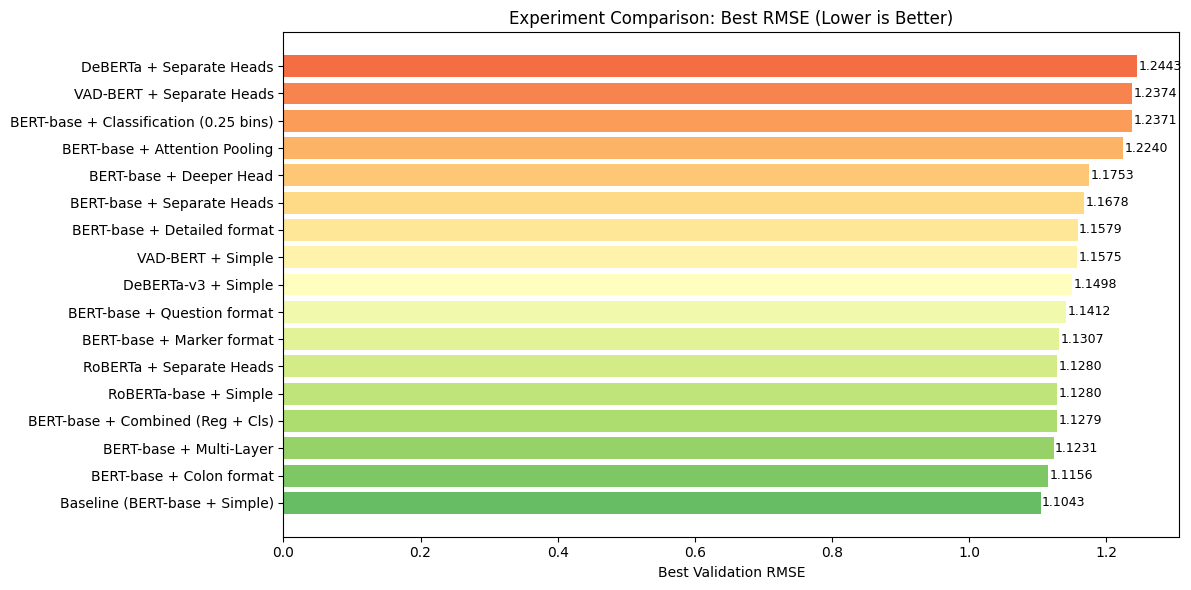

In [41]:
# Visualization: RMSE comparison bar chart
plt.figure(figsize=(12, 6))

names = [r.experiment_name for r in all_results]
rmse_values = [r.best_rmse for r in all_results]

# Sort by RMSE
sorted_pairs = sorted(zip(names, rmse_values), key=lambda x: x[1])
names_sorted, rmse_sorted = zip(*sorted_pairs)

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(names_sorted)))

bars = plt.barh(range(len(names_sorted)), rmse_sorted, color=colors)
plt.yticks(range(len(names_sorted)), names_sorted)
plt.xlabel("Best Validation RMSE")
plt.title("Experiment Comparison: Best RMSE (Lower is Better)")

# Add value labels
for i, (bar, val) in enumerate(zip(bars, rmse_sorted)):
    plt.text(val + 0.002, bar.get_y() + bar.get_height()/2,
             f"{val:.4f}", va='center', fontsize=9)

plt.tight_layout()
plt.savefig("experiment_comparison_rmse.png", dpi=150, bbox_inches="tight")
plt.show()

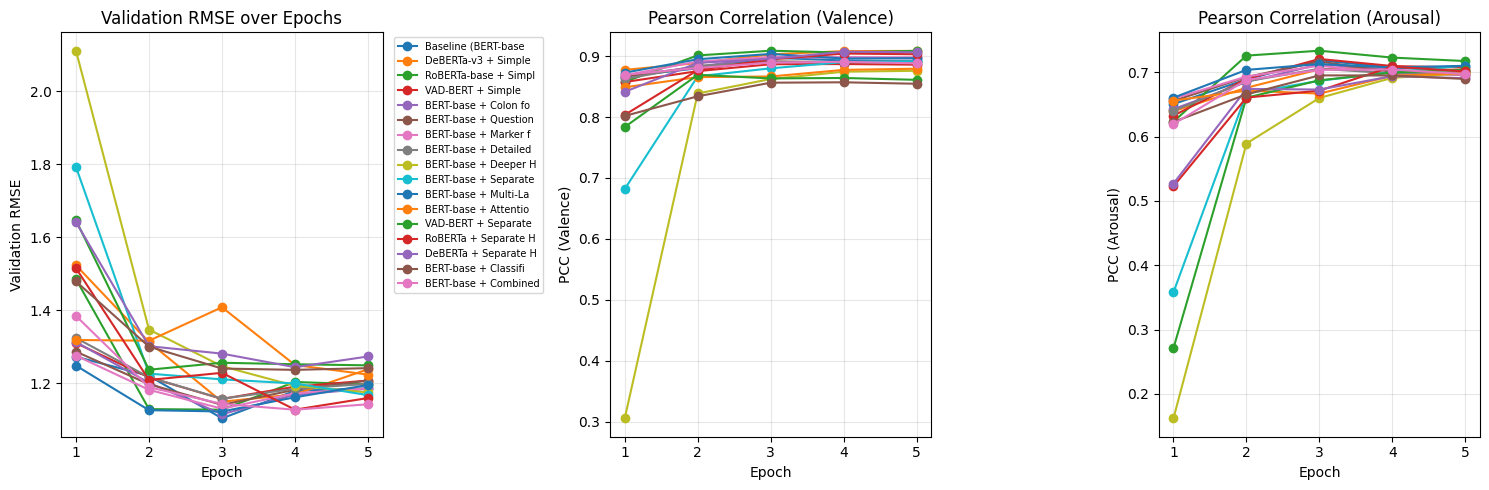

In [42]:
# Visualization: Training curves for all experiments
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE curves
ax1 = axes[0]
for result in all_results:
    ax1.plot(range(1, len(result.val_rmse)+1), result.val_rmse,
             marker='o', label=result.experiment_name[:20])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation RMSE")
ax1.set_title("Validation RMSE over Epochs")
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=7)
ax1.grid(True, alpha=0.3)

# PCC_V curves
ax2 = axes[1]
for result in all_results:
    ax2.plot(range(1, len(result.val_pcc_v)+1), result.val_pcc_v,
             marker='o', label=result.experiment_name[:20])
ax2.set_xlabel("Epoch")
ax2.set_ylabel("PCC (Valence)")
ax2.set_title("Pearson Correlation (Valence)")
ax2.grid(True, alpha=0.3)

# PCC_A curves
ax3 = axes[2]
for result in all_results:
    ax3.plot(range(1, len(result.val_pcc_a)+1), result.val_pcc_a,
             marker='o', label=result.experiment_name[:20])
ax3.set_xlabel("Epoch")
ax3.set_ylabel("PCC (Arousal)")
ax3.set_title("Pearson Correlation (Arousal)")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

In [43]:
# Ablation analysis: Impact of each factor
print("\n" + "="*60)
print("ABLATION ANALYSIS")
print("="*60)

baseline_rmse = result_baseline.best_rmse

improvements = []
for result in all_results:
    if result != result_baseline:
        improvement = (baseline_rmse - result.best_rmse) / baseline_rmse * 100
        improvements.append((result.experiment_name, improvement, result.best_rmse))

improvements.sort(key=lambda x: -x[1])

print(f"\nBaseline RMSE: {baseline_rmse:.4f}")
print(f"\nImprovement over baseline:")
print("-" * 60)
for name, imp, rmse in improvements:
    sign = "+" if imp > 0 else ""
    print(f"{name:40s} | RMSE: {rmse:.4f} | {sign}{imp:.2f}%")


ABLATION ANALYSIS

Baseline RMSE: 1.1043

Improvement over baseline:
------------------------------------------------------------
BERT-base + Colon format                 | RMSE: 1.1156 | -1.02%
BERT-base + Multi-Layer                  | RMSE: 1.1231 | -1.70%
BERT-base + Combined (Reg + Cls)         | RMSE: 1.1279 | -2.14%
RoBERTa-base + Simple                    | RMSE: 1.1280 | -2.15%
RoBERTa + Separate Heads                 | RMSE: 1.1280 | -2.15%
BERT-base + Marker format                | RMSE: 1.1307 | -2.40%
BERT-base + Question format              | RMSE: 1.1412 | -3.34%
DeBERTa-v3 + Simple                      | RMSE: 1.1498 | -4.12%
VAD-BERT + Simple                        | RMSE: 1.1575 | -4.82%
BERT-base + Detailed format              | RMSE: 1.1579 | -4.86%
BERT-base + Separate Heads               | RMSE: 1.1678 | -5.76%
BERT-base + Deeper Head                  | RMSE: 1.1753 | -6.43%
BERT-base + Attention Pooling            | RMSE: 1.2240 | -10.85%
BERT-base + Classificat

## 9. Ensemble Model

In [44]:
def train_ensemble_models(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    n_models: int = 3,
    seeds: List[int] = [42, 123, 456]
) -> List[nn.Module]:
    """
    Train multiple models with different seeds for ensembling.
    """
    models = []
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    for i, seed in enumerate(seeds[:n_models]):
        print(f"\n--- Training ensemble member {i+1}/{n_models} (seed={seed}) ---")
        set_seed(seed)

        train_dataset = DimABSADataset(train_df, tokenizer, input_format="sep")
        val_dataset = DimABSADataset(val_df, tokenizer, input_format="sep")

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        model = SimpleRegressor("bert-base-uncased").to(DEVICE)

        optimizer = AdamW(model.parameters(), lr=2e-5)
        total_steps = len(train_loader) * 5
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps
        )

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            loss_fn=nn.MSELoss(),
            device=DEVICE,
            patience=3
        )

        trainer.train(epochs=5, experiment_name=f"Ensemble_{i+1}")
        models.append(model)

    return models


@torch.no_grad()
def ensemble_predict(models: List[nn.Module], dataloader: DataLoader) -> np.ndarray:
    """
    Average predictions from multiple models.
    """
    all_preds = []

    for model in models:
        model.eval()
        model_preds = []

        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            model_preds.append(outputs.cpu().numpy())

        all_preds.append(np.vstack(model_preds))

    # Average predictions
    ensemble_preds = np.mean(all_preds, axis=0)
    return ensemble_preds

In [45]:
# Train ensemble (this takes time - 3 models x 5 epochs)
print("\n" + "="*60)
print("TRAINING ENSEMBLE MODELS")
print("="*60)

ensemble_models = train_ensemble_models(train_df, val_df, n_models=3)

# Evaluate ensemble
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
val_dataset = DimABSADataset(val_df, tokenizer, input_format="sep")
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

ensemble_preds = ensemble_predict(ensemble_models, val_loader)
val_labels = np.vstack([batch["labels"].numpy() for batch in val_loader])

ensemble_metrics = compute_metrics(ensemble_preds, val_labels)

print(f"\n{'='*60}")
print(f"ENSEMBLE RESULTS (3 models)")
print(f"{'='*60}")
print(f"RMSE (raw):  {ensemble_metrics['rmse']:.4f}")
print(f"RMSE (norm): {ensemble_metrics['rmse_norm']:.4f}")
print(f"PCC_V: {ensemble_metrics['pcc_v']:.4f}")
print(f"PCC_A: {ensemble_metrics['pcc_a']:.4f}")
print(f"\n--- Official Metrics Format ---")
print(f"PCC_V: {ensemble_metrics['pcc_v']:.4f}")
print(f"PCC_A: {ensemble_metrics['pcc_a']:.4f}")
print(f"RMSE_VA: {ensemble_metrics['rmse_norm']:.4f}")


TRAINING ENSEMBLE MODELS

--- Training ensemble member 1/3 (seed=42) ---


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 8.6138 | Val Loss: 0.8006 | RMSE: 1.2731 | RMSE_norm: 0.1125 | PCC_V: 0.8666 | PCC_A: 0.6506


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6671 | Val Loss: 0.7341 | RMSE: 1.2207 | RMSE_norm: 0.1079 | PCC_V: 0.8800 | PCC_A: 0.6889


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4575 | Val Loss: 0.6007 | RMSE: 1.1043 | RMSE_norm: 0.0976 | PCC_V: 0.8975 | PCC_A: 0.7186


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3356 | Val Loss: 0.6852 | RMSE: 1.1797 | RMSE_norm: 0.1043 | PCC_V: 0.8929 | PCC_A: 0.7074


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2665 | Val Loss: 0.6942 | RMSE: 1.1865 | RMSE_norm: 0.1049 | PCC_V: 0.8919 | PCC_A: 0.7022

--- Training ensemble member 2/3 (seed=123) ---


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 7.7437 | Val Loss: 1.2206 | RMSE: 1.5713 | RMSE_norm: 0.1389 | PCC_V: 0.8277 | PCC_A: 0.5793


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6549 | Val Loss: 0.7450 | RMSE: 1.2284 | RMSE_norm: 0.1086 | PCC_V: 0.8890 | PCC_A: 0.6871


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4311 | Val Loss: 0.8175 | RMSE: 1.2869 | RMSE_norm: 0.1137 | PCC_V: 0.8911 | PCC_A: 0.6929


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3166 | Val Loss: 0.6540 | RMSE: 1.1514 | RMSE_norm: 0.1018 | PCC_V: 0.8991 | PCC_A: 0.7153


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2575 | Val Loss: 0.6835 | RMSE: 1.1770 | RMSE_norm: 0.1040 | PCC_V: 0.8986 | PCC_A: 0.7162

--- Training ensemble member 3/3 (seed=456) ---


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 8.0758 | Val Loss: 0.7954 | RMSE: 1.2699 | RMSE_norm: 0.1122 | PCC_V: 0.8598 | PCC_A: 0.6285


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.6771 | Val Loss: 0.8314 | RMSE: 1.2965 | RMSE_norm: 0.1146 | PCC_V: 0.8853 | PCC_A: 0.6801


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4577 | Val Loss: 0.6623 | RMSE: 1.1589 | RMSE_norm: 0.1024 | PCC_V: 0.8951 | PCC_A: 0.6980


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.3269 | Val Loss: 0.7034 | RMSE: 1.1937 | RMSE_norm: 0.1055 | PCC_V: 0.8934 | PCC_A: 0.6970


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2672 | Val Loss: 0.6880 | RMSE: 1.1813 | RMSE_norm: 0.1044 | PCC_V: 0.8936 | PCC_A: 0.7045

ENSEMBLE RESULTS (3 models)
RMSE (raw):  1.1048
RMSE (norm): 0.0977
PCC_V: 0.9020
PCC_A: 0.7194

--- Official Metrics Format ---
PCC_V: 0.9020
PCC_A: 0.7194
RMSE_VA: 0.0977


## 9.5 Generate Predictions for Official Evaluation

This section shows how to generate predictions in the official JSONL format for submission to CodaBench or local evaluation with the official script.

In [ ]:
def generate_predictions_task1(
    model: nn.Module,
    test_data: List[Dict],
    tokenizer,
    device: torch.device,
    max_len: int = 256,
    input_format: str = "sep"
) -> List[Dict]:
    """
    Generate predictions in official Task 1 format.

    Input format (test_data):
        {"ID": "...", "Text": "...", "Aspect": ["aspect1", "aspect2", ...]}

    Output format:
        {"ID": "...", "Aspect_VA": [{"Aspect": "...", "VA": "V.VV#A.AA"}, ...]}
    """
    model.eval()
    predictions = []

    # Select format function
    format_map = {
        "sep": InputFormat.sep_format,
        "colon": InputFormat.colon_format,
        "question": InputFormat.question_format,
        "marker": InputFormat.marker_format,
        "detailed": InputFormat.detailed_format
    }
    format_fn = format_map.get(input_format, InputFormat.sep_format)

    with torch.no_grad():
        for item in tqdm(test_data, desc="Generating predictions"):
            item_id = item["ID"]
            text = item["Text"]
            aspects = item["Aspect"]

            aspect_va_list = []
            for aspect in aspects:
                # Create input
                input_text = format_fn(text, aspect)

                # Tokenize
                encoded = tokenizer(
                    input_text,
                    truncation=True,
                    padding="max_length",
                    max_length=max_len,
                    return_tensors="pt"
                )

                input_ids = encoded["input_ids"].to(device)
                attention_mask = encoded["attention_mask"].to(device)

                # Predict
                outputs = model(input_ids, attention_mask)
                pred_v, pred_a = outputs[0].cpu().numpy()

                pred_v = np.clip(pred_v, 1.0, 9.0)
                pred_a = np.clip(pred_a, 1.0, 9.0)

                va_str = f"{pred_v:.2f}#{pred_a:.2f}"

                aspect_va_list.append({
                    "Aspect": aspect,
                    "VA": va_str
                })

            predictions.append({
                "ID": item_id,
                "Aspect_VA": aspect_va_list
            })

    return predictions


def save_predictions_jsonl(predictions: List[Dict], filepath: str):
    """Save predictions to JSONL file for official evaluation."""
    with open(filepath, 'w', encoding='utf-8') as f:
        for pred in predictions:
            f.write(json.dumps(pred, ensure_ascii=False) + '\n')
    print(f"Saved {len(predictions)} predictions to {filepath}")


def load_test_data(url_or_path: str) -> List[Dict]:
    """Load test data from URL or local file."""
    if url_or_path.startswith('http'):
        resp = requests.get(url_or_path)
        resp.raise_for_status()
        return [json.loads(line) for line in resp.text.splitlines()]
    else:
        with open(url_or_path, 'r', encoding='utf-8') as f:
            return [json.loads(line) for line in f]


print("Prediction generation functions defined.")
print("\nTo generate predictions:")
print("  1. Load your trained model")
print("  2. Load test data with load_test_data(url_or_path)")
print("  3. Call generate_predictions_task1(model, test_data, tokenizer, DEVICE)")
print("  4. Save with save_predictions_jsonl(predictions, 'pred.jsonl')")
print("\nTo evaluate locally:")
print("  python evaluate.py -p pred.jsonl -g gold.jsonl -t 1 --do_norm")

Prediction generation functions defined.

To generate predictions:
  1. Load your trained model
  2. Load test data with load_test_data(url_or_path)
  3. Call generate_predictions_task1(model, test_data, tokenizer, DEVICE)
  4. Save with save_predictions_jsonl(predictions, 'pred.jsonl')

To evaluate locally:
  python evaluate.py -p pred.jsonl -g gold.jsonl -t 1 --do_norm


In [47]:
# Example: Generate predictions on dev set and evaluate
# (This uses the validation set as a stand-in for the dev/test set)

# Load dev data in original format (with aspects)
dev_url = config.dev_url
print(f"Loading dev data from: {dev_url}")

try:
    dev_data = load_test_data(dev_url)
    print(f"Loaded {len(dev_data)} dev samples")

    # Show sample
    print("\nSample input:")
    print(json.dumps(dev_data[0], indent=2))
except Exception as e:
    print(f"Could not load dev data: {e}")
    print("You can manually load test data and generate predictions.")

Loading dev data from: https://raw.githubusercontent.com/DimABSA/DimABSA2026/refs/heads/main/task-dataset/track_a/subtask_1/eng/eng_laptop_dev_task1.jsonl
Loaded 200 dev samples

Sample input:
{
  "ID": "lap26_aspect_va_dev_1",
  "Text": "The touchscreen works very well",
  "Aspect": [
    "touchscreen"
  ]
}


## 10. Final Summary & Recommendations

In [48]:
# Add ensemble to summary
summary_data.append({
    "Experiment": "Ensemble (3 models)",
    "Best RMSE": ensemble_metrics['rmse'],
    "RMSE_norm": ensemble_metrics['rmse_norm'],
    "Best Epoch": "-",
    "Final PCC_V": ensemble_metrics['pcc_v'],
    "Final PCC_A": ensemble_metrics['pcc_a'],
    "Model": "BERT-base x3",
    "Architecture": "simple",
    "Input Format": "sep"
})

final_summary = pd.DataFrame(summary_data)
final_summary = final_summary.sort_values("Best RMSE")

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print("Metrics match official DimABSA evaluation:")
print("  - RMSE_norm = RMSE / sqrt(128)")
print("  - PCC_V, PCC_A = Pearson correlation")
print()
print(final_summary.to_string(index=False))


FINAL RESULTS SUMMARY
Metrics match official DimABSA evaluation:
  - RMSE_norm = RMSE / sqrt(128)
  - PCC_V, PCC_A = Pearson correlation

                            Experiment  Best RMSE  RMSE_norm Best Epoch  Final PCC_V  Final PCC_A             Model      Architecture Input Format
         Baseline (BERT-base + Simple)   1.104269   0.097605          3     0.891912     0.702178 bert-base-uncased            simple          sep
                   Ensemble (3 models)   1.104816   0.097653          -     0.901952     0.719380      BERT-base x3            simple          sep
              BERT-base + Colon format   1.115577   0.098604          3     0.896294     0.696128 bert-base-uncased            simple        colon
               BERT-base + Multi-Layer   1.123089   0.099268          3     0.896709     0.710018 bert-base-uncased       multi_layer          sep
      BERT-base + Combined (Reg + Cls)   1.127925   0.099695          4     0.888203     0.697163 bert-base-uncased          c

In [51]:
# Find best experiment
best_exp = final_summary.iloc[0]
print(f"\n{'='*80}")
print("BEST CONFIGURATION")
print(f"{'='*80}")
print(f"Experiment:    {best_exp['Experiment']}")
print(f"RMSE:          {best_exp['Best RMSE']:.4f}")
print(f"PCC_V:         {best_exp['Final PCC_V']:.4f}")
print(f"PCC_A:         {best_exp['Final PCC_A']:.4f}")




BEST CONFIGURATION
Experiment:    Baseline (BERT-base + Simple)
RMSE:          1.1043
PCC_V:         0.8919
PCC_A:         0.7022


In [50]:
# Save results to CSV
final_summary.to_csv("experiment_results.csv", index=False)
print("Results saved to 'experiment_results.csv'")

Results saved to 'experiment_results.csv'


In [52]:
#==== Step 5: Save & Submit Predictions ====
import os
import re
import json
import shutil
import zipfile
import requests
from google.colab import files

# Helper to sort IDs numerically
def extract_num(s):
    m = re.search(r"(\d+)$", str(s))
    return int(m.group(1)) if m else -1

# 1. Identify Best Model Configuration
best_exp_row = final_summary.iloc[0]
best_exp_name = best_exp_row['Experiment']
print(f"Selected Best Model from Experiments: {best_exp_name}")
print(f"  RMSE: {best_exp_row['Best RMSE']:.4f}")

model_to_use = None
tokenizer = None
input_format = best_exp_row['Input Format']

# Check if it's the ensemble
if "Ensemble" in best_exp_name and 'ensemble_models' in globals():
    print("Using trained Ensemble models.")
    class EnsembleWrapper(nn.Module):
        def __init__(self, models):
            super().__init__()
            self.models = models
        def forward(self, input_ids, attention_mask):
            outputs = [model(input_ids, attention_mask) for model in self.models]
            return torch.mean(torch.stack(outputs), dim=0)

    model_to_use = EnsembleWrapper(ensemble_models)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

else:
    # Retrieve full config and Retrain
    print(f"Retraining best configuration: {best_exp_row['Model']} ({best_exp_row['Architecture']})")
    best_res = next((r for r in all_results if r.experiment_name == best_exp_name), None)

    if best_res:
        cfg = best_res.config
        model_name = cfg['model_name']
        architecture = cfg['architecture']
        input_format = cfg['input_format']

        tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Re-train on training data
        train_ds = DimABSADataset(train_df, tokenizer, input_format=input_format)
        val_ds = DimABSADataset(val_df, tokenizer, input_format=input_format)
        train_loader = DataLoader(train_ds, batch_size=cfg['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=cfg['batch_size'], shuffle=False)

        model_class = MODEL_REGISTRY[architecture]
        model_to_use = model_class(model_name, dropout=cfg['dropout']).to(DEVICE)

        optimizer = AdamW(model_to_use.parameters(), lr=cfg['lr'])
        scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader)*5)

        # Train loop
        model_to_use.train()
        for epoch in range(5):
            for batch in tqdm(train_loader, desc=f"Retraining Epoch {epoch+1}", leave=False):
                input_ids = batch["input_ids"].to(DEVICE)
                mask = batch["attention_mask"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)

                optimizer.zero_grad()
                out = model_to_use(input_ids, mask)
                if isinstance(out, tuple): out = out[0] # Handle combined model output
                loss = nn.MSELoss()(out, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()
    else:
        raise ValueError("Could not find configuration for best model.")

# 2. Load Prediction Data (Try Test, fallback to Dev)
# Construct potential test URL
test_url = config.dev_url.replace("dev", "test")
print(f"\nAttempting to load test data from: {test_url}")

try:
    predict_data = load_test_data(test_url)
    print(f"Loaded {len(predict_data)} TEST samples.")
except Exception:
    print("Could not load test data (might not be released yet).")
    print("Falling back to DEV data for demonstration.")
    predict_data = load_test_data(config.dev_url)

# 3. Generate Predictions
print("Generating predictions...")
predictions = generate_predictions_task1(
    model=model_to_use,
    test_data=predict_data,
    tokenizer=tokenizer,
    device=DEVICE,
    input_format=input_format
)

# 4. Save to JSONL (Sorted)
# Sort by ID number
predictions.sort(key=lambda x: extract_num(x['ID']))

output_filename = f"pred_{config.lang}_{config.domain}.jsonl"
subtask_dir = config.subtask
os.makedirs(subtask_dir, exist_ok=True)
output_path = os.path.join(subtask_dir, output_filename)

with open(output_path, 'w', encoding='utf-8') as f:
    for pred in predictions:
        f.write(json.dumps(pred, ensure_ascii=False) + '\n')

print(f"Predictions saved to {output_path}")

# 5. Zip and Download
zip_filename = f"{subtask_dir}.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
    zf.write(output_path, os.path.basename(output_path))

print(f"Submission file created: {zip_filename}")
files.download(zip_filename)

Selected Best Model from Experiments: Baseline (BERT-base + Simple)
  RMSE: 1.1043
Retraining best configuration: bert-base-uncased (simple)


Retraining Epoch 1:   0%|          | 0/222 [00:00<?, ?it/s]

Retraining Epoch 2:   0%|          | 0/222 [00:00<?, ?it/s]

Retraining Epoch 3:   0%|          | 0/222 [00:00<?, ?it/s]

Retraining Epoch 4:   0%|          | 0/222 [00:00<?, ?it/s]

Retraining Epoch 5:   0%|          | 0/222 [00:00<?, ?it/s]


Attempting to load test data from: https://raw.githubusercontent.com/DimABSA/DimABSA2026/refs/heads/main/task-dataset/track_a/subtask_1/eng/eng_laptop_test_task1.jsonl
Could not load test data (might not be released yet).
Falling back to DEV data for demonstration.
Generating predictions...


Generating predictions:   0%|          | 0/200 [00:00<?, ?it/s]

Predictions saved to subtask_1/pred_eng_laptop.jsonl
Submission file created: subtask_1.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>